# Codecademy Portfolio Project - Life Expectancy & GDP

## Project Goal:
Identify the relationship between life expectancy and GDP for six countries.

### Key Question:
Is the increase in GDP the primary driver of increase in life expectancy?

## 1. Import All Libraries

In [233]:
## Pandas and Numpy
import pandas as pd
import numpy as np
import math

## Data Visualisation Modules
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm, ListedColormap, LogNorm

## Libraries for API
import requests
import json

## Warnings
import warnings
warnings.filterwarnings("ignore")

# import tabulate
from tabulate import tabulate 

## 2. Pre-Process the Data

### 2.1 Load & Inspect the Data

In [2]:
df = pd.read_csv("all_data.csv") ## Load the csv file and save as a dataframe

In [3]:
df.head() ## Inspect the dataframe

,Country,Year,Life expectancy at birth (years),GDP
0,Chile,2000,77.3,7.786093e+10
1,Chile,2001,77.3,7.097992e+10
2,Chile,2002,77.8,6.973681e+10
3,Chile,2003,77.9,7.564346e+10
4,Chile,2004,78.0,9.921039e+10


Analysis:
- For each country, there are data for each year and and corresponding life expectancy and GDP.    

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           96 non-null     object 
 1   Year                              96 non-null     int64  
 2   Life expectancy at birth (years)  96 non-null     float64
 3   GDP                               96 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.1+ KB


Analysis:
- There are 4 columns: "Country", "Year", "Life expectancy at birth (years)", and "GDP".
- There are 96 non-null values in total for each column.
- The "Country" column consists of object type (string)
- Other columns consist of integers or floats.

In [5]:
df.Country.unique()

array(['Chile', 'China', 'Germany', 'Mexico', 'United States of America',
       'Zimbabwe'], dtype=object)

We have data for the following countries:
- Chile
- China
- Germany
- Mexico
- United States of America
- Zimbabwe
<br>
<br>
We should shorten the name "United States of America" to "USA"

In [6]:
df.Country = df.Country.replace({"United States of America": "USA"}) \
## Replace "United States of America" to "USA"

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,96.0,2.007500e+03,4.633971e+00,2.000000e+03,2.003750e+03,2.007500e+03,2.011250e+03,2.015000e+03
Life expectancy at birth (years),96.0,7.278958e+01,1.067288e+01,4.430000e+01,7.447500e+01,7.675000e+01,7.890000e+01,8.100000e+01
GDP,96.0,3.880499e+12,5.197561e+12,4.415703e+09,1.733018e+11,1.280220e+12,4.067510e+12,1.810000e+13


Analysis:
- The data is from year 2000 to 2015.
- The average life expectancy for all countries is ~72.8 years, with a minimum of 44.3 years and a maximum of 81.0 years.
- The average GDP is 3.88 trillion dollars, with a minimum of 4.42 billion dollars, and a maximum of 18.1 trillion dollars.
- Since the minimum GDP is in the order of 1e+9, we can divide all numbers in the GDP column to reduce the number of zeros so the numbers are easier to handle.
- The column names are in title format, and we will change them to a lowercase format, for easier typing.
- Also, the column name for life expectancy is too long: we will shorten this to "life_exp"
- __Overall, there are no out of ordinary values present in the data, so the data is considered clean.__

### 2.2 Data Cleaning

In [8]:
for col in df.columns:
    df.rename(columns = {col:col.lower()}, inplace = True) ## Change the column names to lowercase

In [9]:
df.rename(columns = {"life expectancy at birth (years)": "life_exp"}, inplace = True)
## Shorten the life expectancy column to "life_exp"

In [10]:
df

,country,year,life_exp,gdp
0,Chile,2000,77.3,7.786093e+10
1,Chile,2001,77.3,7.097992e+10
2,Chile,2002,77.8,6.973681e+10
3,Chile,2003,77.9,7.564346e+10
4,Chile,2004,78.0,9.921039e+10
...,...,...,...,...
91,Zimbabwe,2011,54.9,1.209845e+10
92,Zimbabwe,2012,56.6,1.424249e+10
93,Zimbabwe,2013,58.0,1.545177e+10
94,Zimbabwe,2014,59.2,1.589105e+10


In [11]:
df.gdp = df.gdp.apply(lambda x: x/1e+9) ## Divide the values of GDP column by one billion

In [12]:
df.gdp.describe()

count       96.000000
mean      3880.498571
std       5197.561311
min          4.415703
25%        173.301750
50%       1280.220000
75%       4067.510000
max      18100.000000
Name: gdp, dtype: float64

The spread of GDP is quite wide. We should expect quite a few outliers affecting the mean (as we can see, the median value is only about a third of the mean, so the data is very skewed)

In [13]:
df.isnull().sum() ## Check if there are any missing values.

country     0
year        0
life_exp    0
gdp         0
dtype: int64

There are no missing values so we can now proceed to analysing the data.

We will also create another column called "year_date" that is in datetime format.

In [14]:
df["year_date"] = pd.to_datetime(df["year"], format="%Y")

In [15]:
df.year_date

0    2000-01-01
1    2001-01-01
2    2002-01-01
3    2003-01-01
4    2004-01-01
        ...    
91   2011-01-01
92   2012-01-01
93   2013-01-01
94   2014-01-01
95   2015-01-01
Name: year_date, Length: 96, dtype: datetime64[ns]

## 3. Data Analysis

Here, we will create a couple of new dataframes that group the data by year, and by country and aggregate life expectancy and gdp values by their mean.

In [16]:
## Create another dataframe that is grouped by year, and values aggregated as mean values
df_group_year = df.groupby(df.year_date).mean()

In [17]:
df_group_year

,year,life_exp,gdp
year_date,,,
2000-01-01,2000.0,70.766667,2371.583148
2001-01-01,2001.0,70.833333,2448.751885
2002-01-01,2002.0,70.950000,2561.221488
2003-01-01,2003.0,71.033333,2743.445842
2004-01-01,2004.0,71.300000,2991.647332
2005-01-01,2005.0,71.483333,3207.074369
2006-01-01,2006.0,71.950000,3463.348816
2007-01-01,2007.0,72.300000,3785.749658
2008-01-01,2008.0,72.666667,4055.985617


In [18]:
## Create another dataframe that is grouped by year, and values aggregated as mean values
df_group_country = df.groupby(df.country).mean()

In [19]:
df_group_country

,year,life_exp,gdp
country,,,
Chile,2007.5,78.94375,169.788845
China,2007.5,74.26250,4957.713750
Germany,2007.5,79.65625,3094.775625
Mexico,2007.5,75.71875,976.650625
USA,2007.5,78.06250,14075.000000
Zimbabwe,2007.5,50.09375,9.062580


## 3.1 Change in Life Expectancy Over Time For Each Country and All Countries

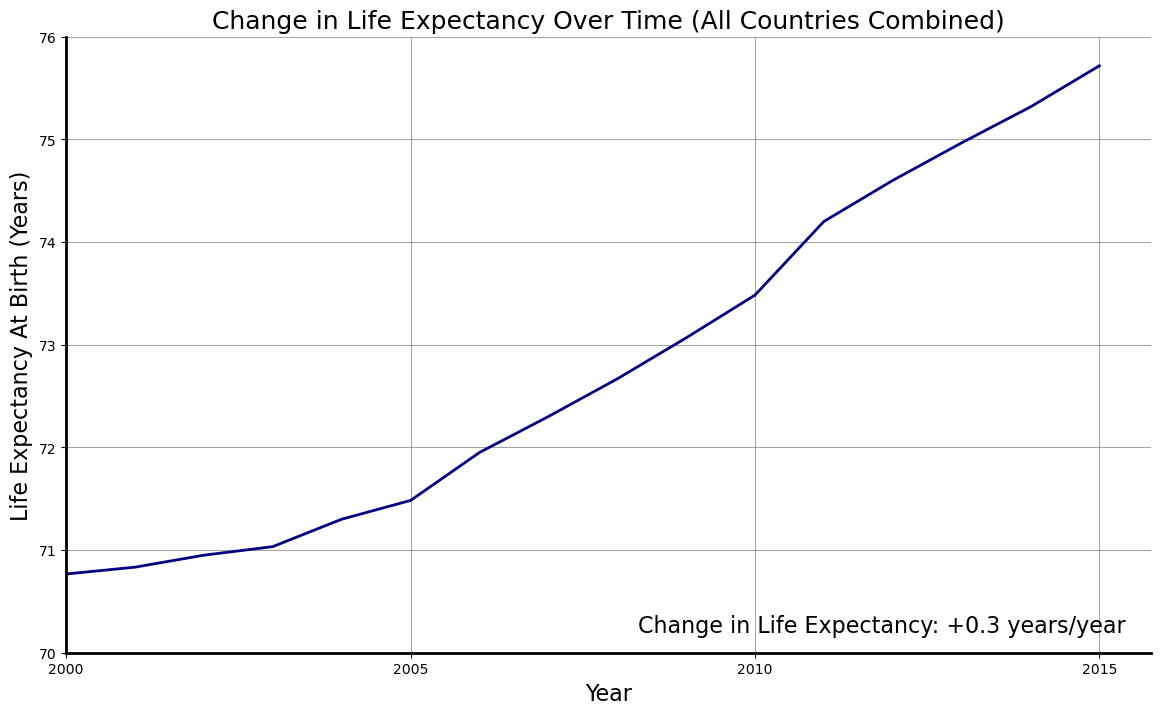

In [20]:
## Rate of Increase in Life Expectancy
init_life = df_group_year.life_exp.loc[(df_group_year.year == 2000)].values[0]
final_life = df_group_year.life_exp.loc[(df_group_year.year == 2015)].values[0]

life_exp_rate_all = round((final_life - init_life) / 15, 1)
label = f"Change in Life Expectancy: +{life_exp_rate_all} years/year"

## Plot a graph for life expectancy of all countries combined
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.lineplot(ax = ax,
             x = "year_date",
             y = "life_exp",
             data = df_group_year,
             color = "navy",
             linewidth = 2)

ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set_ylim(70, 76)
ax.set_xlim(df.year_date.min())
    
plt.title("Change in Life Expectancy Over Time (All Countries Combined)", fontsize=18)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Life Expectancy At Birth (Years)", fontsize=16)

ax.grid(alpha = 0.7, color='gray')

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

sns.despine(ax=ax, offset=0)

ax.annotate(label, (mdates.date2num(df.year_date[8]), 70), xytext=(15, 15), 
            textcoords='offset points', fontsize=16)

plt.show()

Analysis:
- The average life expectancy of all six countries have increased over time by about 6 years in the span of 15 years. This is an increase of about 0.3 years per year.
- Do all countries follow a simiar trend? (i.e. same rate of increase?)

In [21]:
countries = list(df.country.unique())

## Calculate the rate of change in life expectancy per year
life_exp_rate = {}

for country in countries:
    init_life = df.life_exp.loc[(df.country == country) & (df.year == 2000)].values[0]
    final_life = df.life_exp.loc[(df.country == country) & (df.year == 2015)].values[0]
    
    life_exp_rate[country] = round((final_life - init_life) / 15, 1)

In [22]:
life_exp_rate

{'Chile': 0.2,
 'China': 0.3,
 'Germany': 0.2,
 'Mexico': 0.1,
 'USA': 0.2,
 'Zimbabwe': 1.0}

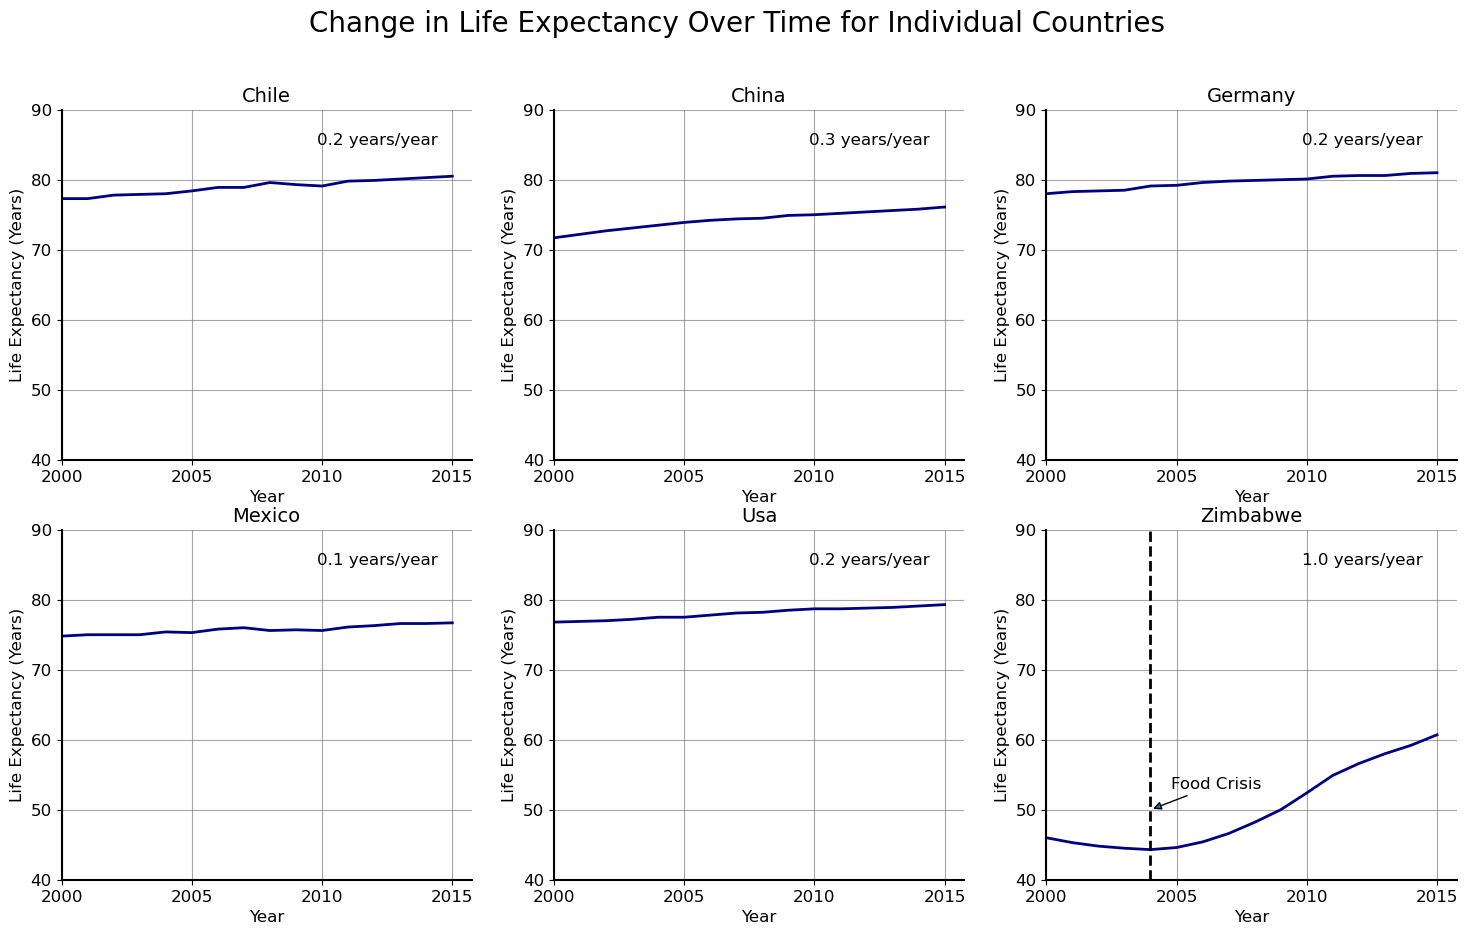

In [23]:
## Plot life expectancy over time for individual countries
nrow = 2
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(18, 10))
plt.rcParams['font.size'] = 12
fig.suptitle(f"Change in Life Expectancy Over Time for Individual Countries",
              fontsize = 20)

for index, country in enumerate(countries):
    ax = plt.subplot(nrow, ncol, index+1)
    label = f"{life_exp_rate[country]} years/year"
    
    sns.lineplot(ax=ax,
                 x = "year_date",
                 y = "life_exp",
                 data = df[df.country == country],
                 color = "navy",
                 linewidth = 2)
    
    ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    
    ax.grid(alpha = 0.7, color='gray')
    ax.set_xlabel(f"Year", fontsize = 12)
    ax.set_ylabel(f"Life Expectancy (Years)", fontsize = 12)
    plt.title(f"{country.title()}", fontsize = 14)
    
    ax.set_ylim(40, 90)
    ax.set_xlim(df.year_date.min())
    
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    sns.despine(ax=ax, offset=0)
    
    ax.annotate(label, (mdates.date2num(df.year_date[9]), 82), xytext=(15, 15), 
            textcoords='offset points')
    
    if country == "Zimbabwe":
        ax.axvline(x=mdates.date2num(df.year_date[4]), color = 'black', lw = 2, ls = "--")
        
        ax.annotate("Food Crisis", (mdates.date2num(df.year_date[4]), 50), xytext=(15, 15), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    
plt.show()

Analysis:
- The life expectancy only increases by no more than 0.3 years/year for most countries except Zimbabwe, which increased by 1 years/year.
- Again, most countries' life expectancy is typically between 70 - 80 years, but Zimbabwe's life expectancy is significantly lower than other countries. It was around 46 years in 2000 and only increased up to around 60 years after 15 years.
- Interestingly, life expectancy for Zimbabwe slightly dipped around 2005. This is most likely the outcome of unprecedented food crisis that Zimbabwe experienced in 2004.

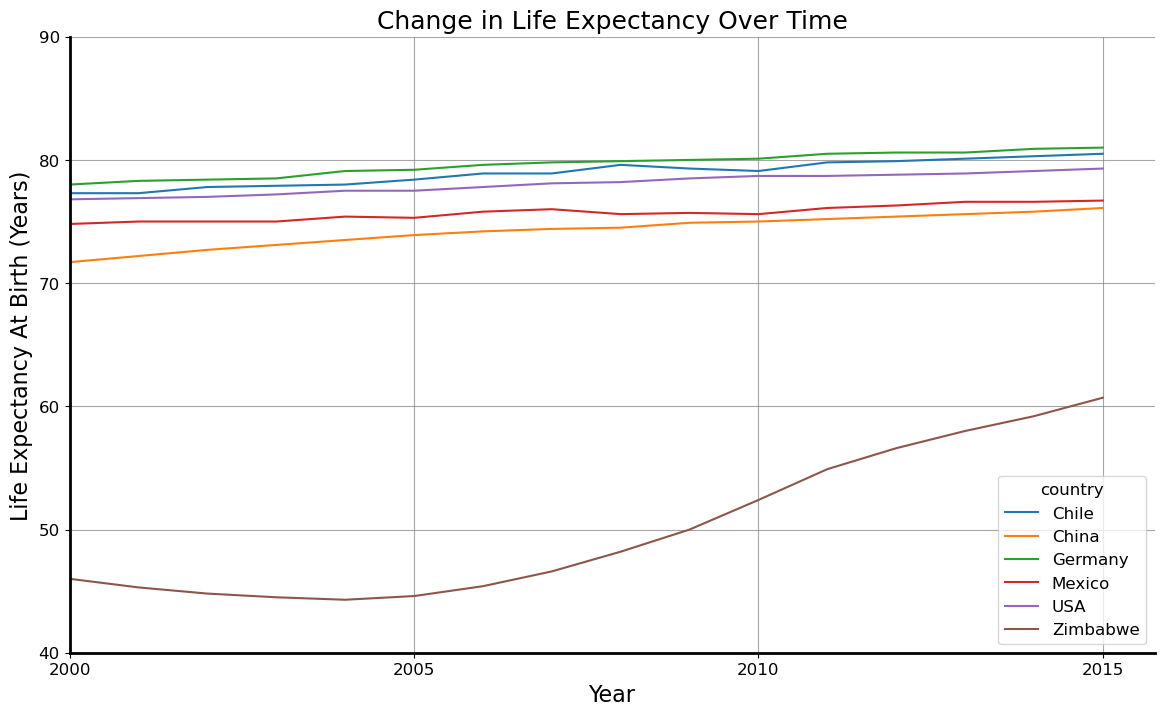

In [24]:
## Plot a graph for life expectancy of all countries in a single plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

sns.lineplot(ax=ax,
             x = "year_date",
             y = "life_exp",
             data = df,
             hue = "country")

ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set_ylim(40, 90)
ax.set_xlim(df.year_date.min())
    
plt.title("Change in Life Expectancy Over Time", fontsize=18)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Life Expectancy At Birth (Years)", fontsize=16)

ax.grid(alpha = 0.7, color='gray')

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

sns.despine(ax=ax, offset=0)

plt.show()

This plot tells the same story as the one above, but I prefer the plot above to this one, because there are six groups, and the color scheme can be difficult to easily comprehend for the readers when there are too many groups.

In [152]:
df_temp = df[["country", "year", "life_exp"]]
df_temp = df_temp.pivot("country","year", "life_exp")
## Create a new temp dataframe and pivot the df for heatmap

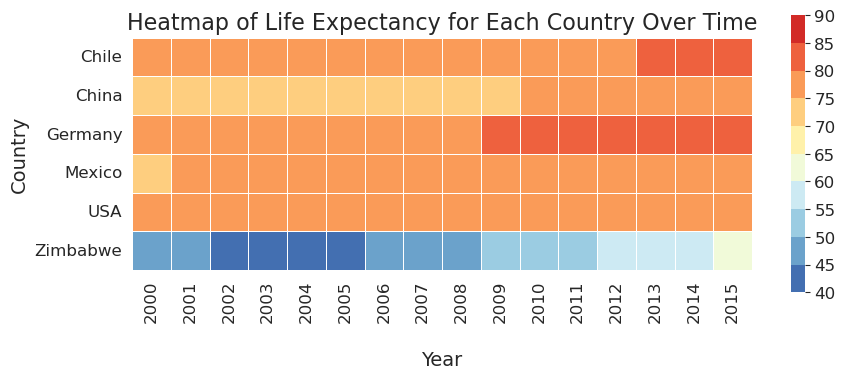

In [176]:
## Heatmap
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10,4))

    my_colors = sns.color_palette("RdYlBu_r", 10)
    my_cmap = ListedColormap(my_colors)
    bounds = np.linspace(40,90,11)
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

    plt.title("Heatmap of Life Expectancy for Each Country Over Time", fontsize = 16)

    sns.heatmap(df_temp,
                cmap=my_cmap,
                norm=my_norm,
                cbar_kws=dict(ticks=bounds, shrink=0.9, location = "right"),
                linewidths=.5,
                square=True)
    
    ax.grid(alpha = 0.7, color='gray')
    plt.xticks(rotation = 90)
    ax.set_xlabel(f"Year", fontsize = 14, labelpad=20)
    ax.set_ylabel(f"Country", fontsize = 14)

Analysis:
- The heatmap plot conveys the similar message as the line plot above but perhaps easier to comprehend.

## 3.2 Change in GDP Over Time For Each Country and All Countries

In [26]:
## This function extracts data from FRED json file and converts to a dataframe
def getFREDData(r, col_name):
    temp_json = r.json()
    temp_dict = {"date": [], col_name: []}
    
    for i in range(len(temp_json["observations"])):
        temp_dict["date"].append(temp_json["observations"][i]["date"])
        temp_dict[col_name].append((temp_json["observations"][i]["value"]))
    
    df = pd.DataFrame.from_dict(temp_dict)
    
    df[col_name] = df[col_name].replace(".", 0)
    df[col_name] = df[col_name].apply(pd.to_numeric)
    
    df.date = pd.to_datetime(df.date) ## Change the date datatype from string to datetime

    return df

In [27]:
## Gather Recession Data for Plotting
fred_key = "604473e68ad090adcb18bf168532fe1a"
## URL for FRED
recession_url = f"https://api.stlouisfed.org/fred/series/observations?series_id=USRECD&api_key={fred_key}&file_type=json"

## Connect to FRED API for recession data
recession_r = requests.get(recession_url)
recession_df = getFREDData(recession_r, "recession")

## Set the start and end dates, and create a mask to mask the values that are within the set dates.
start_date = "2000-1-1"
end_date = "2016-01-01"

## Slice the dataframe to fit within the desired timeframe
mask = (recession_df.date >= start_date) & (recession_df.date <= end_date)
recession_df = recession_df.loc[mask]
recession_df.set_index("date", inplace=True)

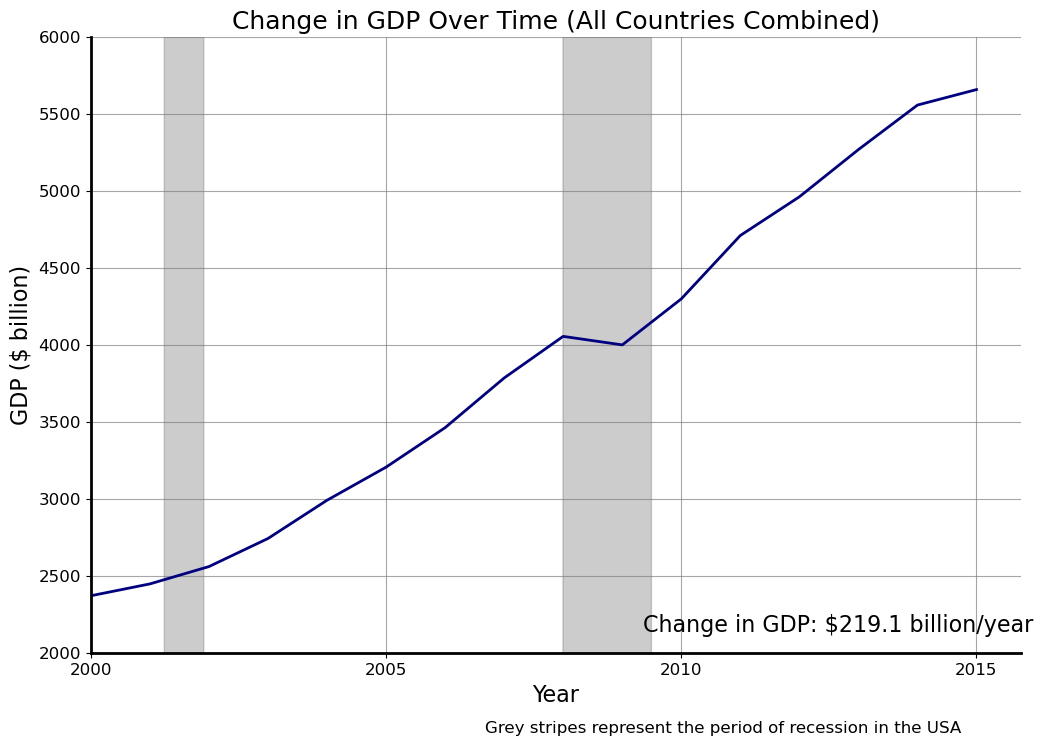

In [28]:
## Rate of Increase in Life Expectancy
init_gdp = df_group_year.gdp.loc[(df_group_year.year == 2000)].values[0]
final_gdp = df_group_year.gdp.loc[(df_group_year.year == 2015)].values[0]

gdp_rate_all = round((final_gdp - init_gdp) / 15, 1)
label = f"Change in GDP: ${gdp_rate_all} billion/year"

## Plot a graph for life expectancy of all countries combined
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(ax = ax,
             x = "year_date",
             y = "gdp",
             data = df_group_year,
             color = "navy",
             linewidth = 2)

ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set_ylim(2000, 6000)
ax.set_xlim(df.year_date.min())
    
plt.title("Change in GDP Over Time (All Countries Combined)", fontsize=18)
plt.xlabel("Year", fontsize=16)
plt.ylabel("GDP ($ billion)", fontsize=16)

ax.grid(alpha = 0.7, color='gray')

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

sns.despine(ax=ax, offset=0)

ax.annotate(label, (mdates.date2num(df.year_date[9]), 2000), xytext=(15, 15), 
            textcoords='offset points', fontsize=16)

## Recession Plot
rx = recession_df.index
ry = recession_df.recession * 6000
ax.fill_between(rx, ry, step="pre", alpha=0.4, color = "grey")
ax.plot(rx, ry, color = "grey", linewidth = 0, markeredgecolor = "none")

txt="Grey stripes represent the period of recession in the USA"
plt.figtext(0.85, 0.01, txt, wrap=True, horizontalalignment='right', fontsize=12) 

plt.show()

Analysis:
- GDP generally increases over time. Here, the average GDP for all six countries combined increased by $219 billion per year.
- There was a slight decrease in GDP in 2007. This is due to the global recession that occurred in 2007 that was triggered by the subprime mortgage crisis in the US.

In [29]:
gdp_rate = {}

## Calculate the rate of GDP per year
for country in countries:
    init_gdp = df.gdp.loc[(df.country == country) & (df.year == 2000)].values[0]
    final_gdp = df.gdp.loc[(df.country == country) & (df.year == 2015)].values[0]
    
    gdp_rate[country] = round((final_gdp - init_gdp) / 15, 1)

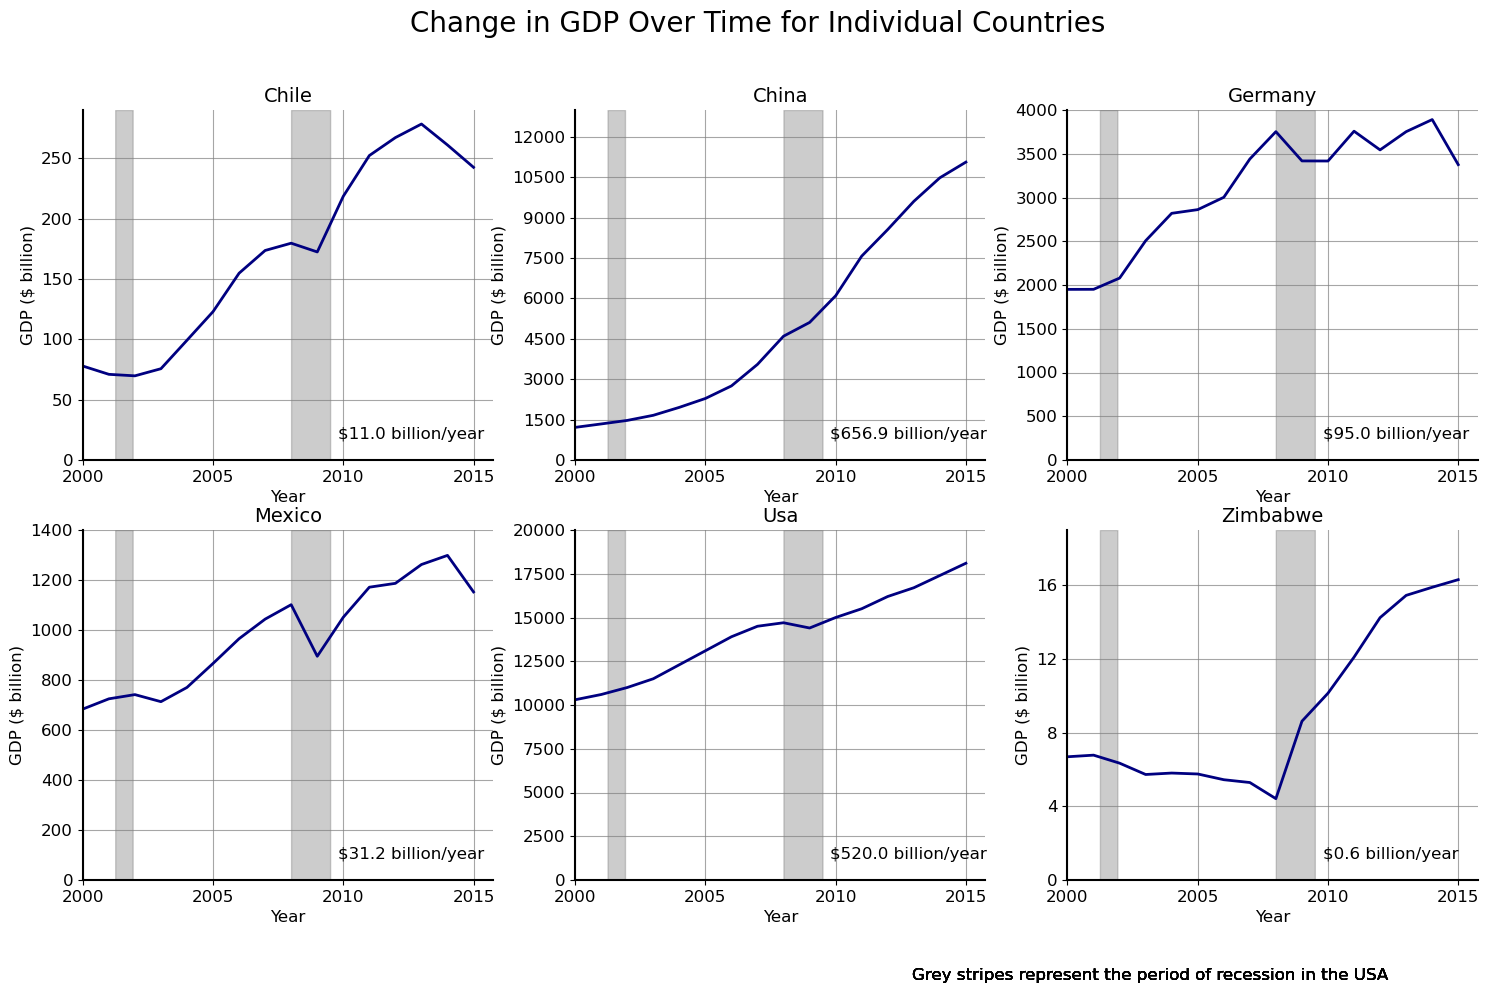

In [30]:
## Plot life expectancy over time for individual countries
nrow = 2
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(18, 10))
plt.rcParams['font.size'] = 12
fig.suptitle(f"Change in GDP Over Time for Individual Countries",
              fontsize = 20)

for index, country in enumerate(countries):
    ax = plt.subplot(nrow, ncol, index+1)
    label = f"${gdp_rate[country]} billion/year"
    
    y = df.gdp[df.country == country]
    ymax = math.ceil(y.max())
    ymin = y.min()
    
    n = int(math.log10(ymax))
    num = 10**(n-1) if n >= 4 else 10**(n-1)
    ymax = int(ymax/num)*num + 2*num
    
    sns.lineplot(ax=ax,
                 x = "year_date",
                 y = "gdp",
                 data = df[df.country == country],
                 color = "navy",
                 linewidth = 2)
    
    ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    
    ax.grid(alpha = 0.7, color='gray')
    ax.set_xlabel(f"Year", fontsize = 12)
    ax.set_ylabel(f"GDP ($ billion)", fontsize = 12)
    plt.title(f"{country.title()}", fontsize = 14)
    
    ax.set_ylim(0, ymax)
    ax.set_xlim(df.year_date.min())
    
    m = n+5
    ax.yaxis.set_major_locator(plt.MaxNLocator(m))
        
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    sns.despine(ax=ax, offset=0)
    
    ax.annotate(label, (mdates.date2num(df.year_date[9]), 0), xytext=(15, 15), 
            textcoords='offset points')
    
    ## Recession Plot
    rx = recession_df.index
    ry = recession_df.recession * ymax
    ax.fill_between(rx, ry, step="pre", alpha=0.4, color = "grey")
    ax.plot(rx, ry, color = "grey", linewidth = 0, markeredgecolor = "none")
    
    txt="Grey stripes represent the period of recession in the USA"
    plt.figtext(0.85, 0.01, txt, wrap=True, horizontalalignment='right', fontsize=12) 
    
plt.show()

Analysis:
- The fastest growing economy in terms of GDP is China, which is growing at almost 660 billion dollars per year.
- The slowest growing economy is Zimbabwe, which is growing at only $600 million per year.
- Most countries have suffered from the recession of 2007, except China and Zimbabwe.
- USA is the largest economy but China is rapidly catching up.

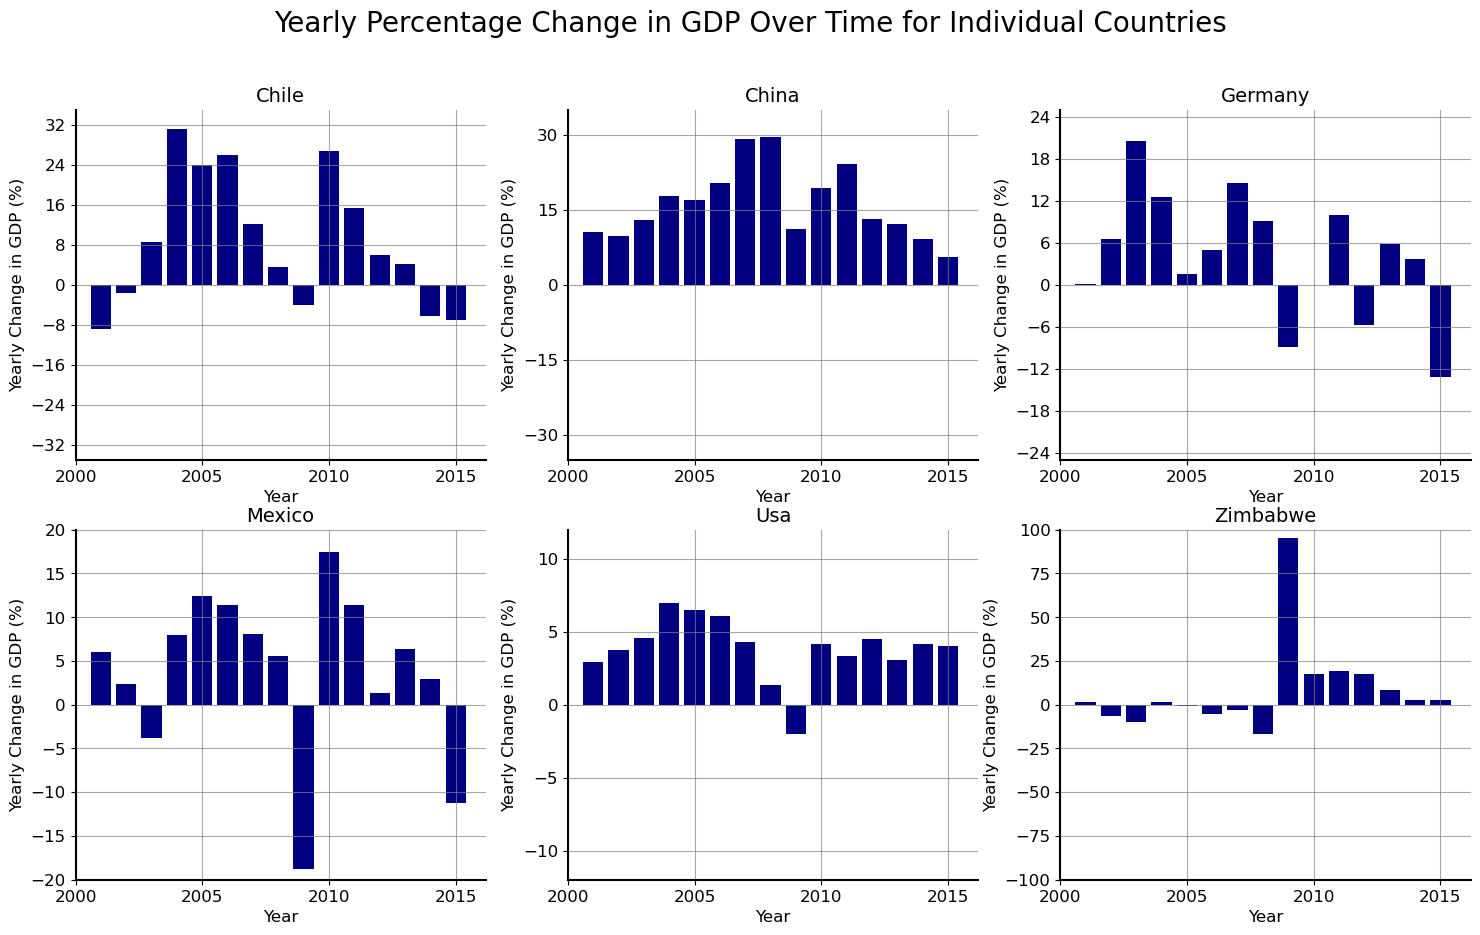

In [31]:
## Plot yearly precentage change in GDP for individual countries
nrow = 2
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(18, 10))
plt.rcParams['font.size'] = 12
fig.suptitle(f"Yearly Percentage Change in GDP Over Time for Individual Countries",
              fontsize = 20)

for index, country in enumerate(countries):
    ax = plt.subplot(nrow, ncol, index+1)
    
    ## Create a new dataframe and a new column showing the yearly change in GDP from previous year
    df_temp = df[df.country == country]
    
    df_temp["gdp_change"] = df_temp["gdp"].pct_change().fillna(0)*100
    df_temp.set_index("year_date", inplace=True)
    
    y = df_temp["gdp_change"]

    ymax = math.ceil(y.max())
    ymin = y.min()
    
    n = int(math.log10(ymax))
    num = 10**n
    ymax = int(ymax/num)*num + 5 if country not in  ["Mexico", "Zimbabwe"] else int(ymax/num)*num + 10
    
    ax.bar(x = "year",
           height = "gdp_change",
           data = df_temp,
           color = "navy")
    
    ax.grid(alpha = 0.7, color='gray')
    ax.set_xlabel(f"Year", fontsize = 12)
    ax.set_ylabel(f"Yearly Change in GDP (%)", fontsize = 12)
    plt.title(f"{country.title()}", fontsize = 14)
    
    ax.set_ylim(-ymax, ymax)
    ax.set_xlim(df_temp.year.min())
    
    m = 9 if country not in ["USA", "China"] else 5
    ax.yaxis.set_major_locator(plt.MaxNLocator(m))
    
    m = 4
    ax.xaxis.set_major_locator(plt.MaxNLocator(m))
        
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    sns.despine(ax=ax, offset=0)
    
plt.show()

Analysis:
- Mexico seems to have suffered the most during the 2007 recession. Its GDP fell by almost 20% from its previous year's GDP.
- Even China experienced negative effect of the 2007 recession. Its economy was constantly growing by more than 15% since 2005, but failed to reach that mark for the first time in 2009. However, it has never experienced negative growth during the timespan.
- Zimbabwe's GDP increased by almost 100% in 2009. This is due to the hyperinflation that occurred in the country in 2008.

In [177]:
df_temp = df[["country", "year", "gdp"]]
df_temp = df_temp.pivot("country","year", "gdp")
## Create a new temp dataframe and pivot the df for heatmap

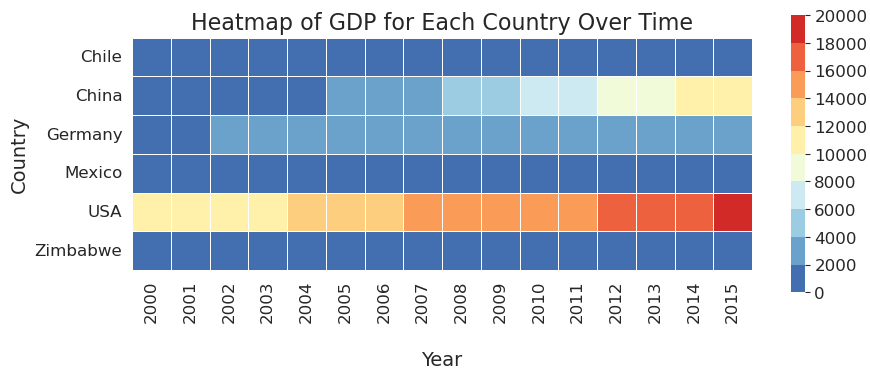

In [192]:
## Heatmap
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10,4))

    my_colors = sns.color_palette("RdYlBu_r", 10)
    my_cmap = ListedColormap(my_colors)
    bounds = np.linspace(0,20000,11)
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

    plt.title("Heatmap of GDP for Each Country Over Time", fontsize = 16)

    sns.heatmap(df_temp,
                cmap=my_cmap,
                norm=my_norm,
                cbar_kws=dict(ticks=bounds, shrink=0.9, location = "right"),
                linewidths=.5,
                square=True)
    
    ax.grid(alpha = 0.7, color='gray')
    plt.xticks(rotation = 90)
    ax.set_xlabel(f"Year", fontsize = 14, labelpad=20)
    ax.set_ylabel(f"Country", fontsize = 14)

Analysis:
- The heatmap shows how the size of other economies pales in comparison to the size of the US economy in terms of GDP.
- Only recently did China manage to "catch" the USA, but still quite further away.
- The heatmap does not distinguish between the low GDP countries. Zimbabwe's GDP is significantly lower than Chile and Mexico but this is not clearly shown.

## 3.3 Relationship Between GDP and Life Expectancy

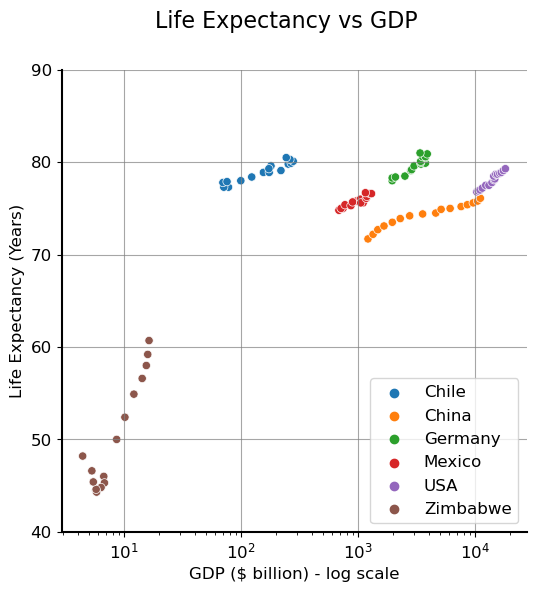

In [33]:
## Plot a scatterplot for life expectancy and gdp of all countries combined
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plt.rcParams['font.size'] = 12
fig.suptitle(f"Life Expectancy vs GDP",
              fontsize = 16)

sns.scatterplot(ax=ax,
                x="gdp",
                y="life_exp",
                data=df,
                hue="country")

ax.set_xscale('log')
ax.set_ylim(40, 90)

ax.grid(alpha = 0.7, color='gray')
ax.set_xlabel(f"GDP ($ billion) - log scale", fontsize = 12)
ax.set_ylabel(f"Life Expectancy (Years)", fontsize = 12)

ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

sns.despine(ax=ax, offset=0)

plt.legend(loc = "lower right")
plt.show()

Analysis:
- There seems to be a linear relationship between GDP and life expectancy.
- Zimbabwe has some outliers, and its values are also significantly smaller than other countries, so we will re-examine this plot with Zimbabwe excluded.

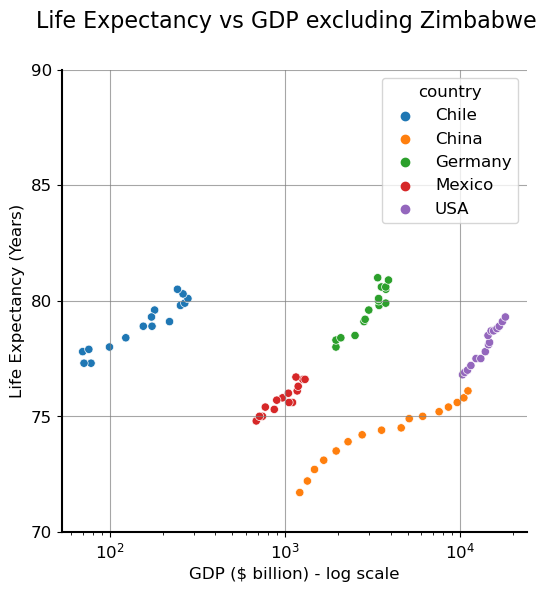

In [34]:
df_temp = df[df.country != "Zimbabwe"]
## Plot a scatterplot for life expectancy and gdp of all countries combined excluding Zimbabwe
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plt.rcParams['font.size'] = 12
fig.suptitle(f"Life Expectancy vs GDP excluding Zimbabwe",
              fontsize = 16)

sns.scatterplot(ax=ax,
                x="gdp",
                y="life_exp",
                data=df_temp,
                hue="country")

ax.set_xscale('log')
ax.set_ylim(70, 90)

ax.grid(alpha = 0.7, color='gray')
ax.set_xlabel(f"GDP ($ billion) - log scale", fontsize = 12)
ax.set_ylabel(f"Life Expectancy (Years)", fontsize = 12)

m = 4
ax.yaxis.set_major_locator(plt.MaxNLocator(m))

ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

sns.despine(ax=ax, offset=0)

Analysis:
- On a closer inspection, there is a linear relationship between GDP and life expectancy. However, this relationship is only evident when the data is examined individually by country.
- GDP does not seem to be the primary reason for higher life expectancy. Countries with lower GDP such as Chile has a higher life expectancy than China, which has a much higher GDP.
- So the GDP contributes to the increase in life expectancy for each country, but there are also other factors involved that are not present in the dataset that influence life expectancy.

In [36]:
## Life Expectancy & GDP correlation

In [73]:
print("The overall Pearson correlation coefficient: ", round(np.corrcoef(df.life_exp, df.gdp)[0,1], 2))

The overall Pearson correlation coefficient:  0.34


The overall correlation is 0.34, which does not take into account the differences between countries.

In [74]:
corr = {}

## Calculate Pearson correlation coefficient for each country
for country in countries:
    c = round(np.corrcoef(df.life_exp[df.country == country], 
                          df.gdp[df.country == country])[0,1], 2)
    corr[country] = c

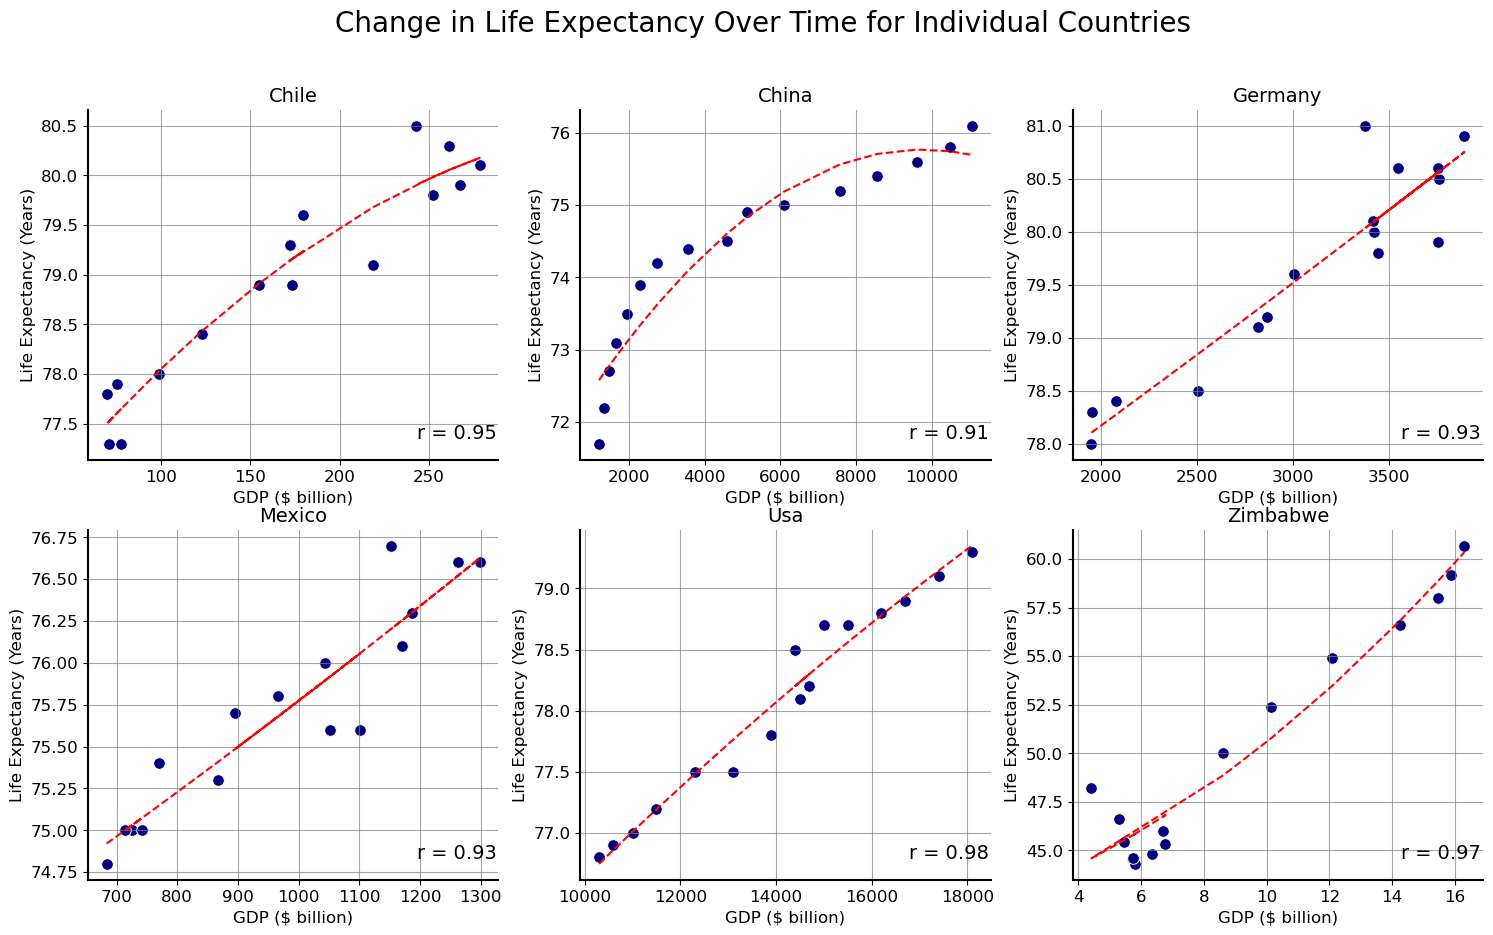

In [123]:
## Plot life expectancy over time for individual countries
nrow = 2
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(18, 10))
plt.rcParams['font.size'] = 12
fig.suptitle(f"Change in Life Expectancy Over Time for Individual Countries",
              fontsize = 20)

for index, country in enumerate(countries):
    ax = plt.subplot(nrow, ncol, index+1)
    x = df.gdp[df.country == country]
    y = df.life_exp[df.country == country]
    
    sns.scatterplot(ax=ax,
                    x = "gdp",
                    y = "life_exp",
                    data = df[df.country == country],
                    color = "navy",
                    s = 70)
    
    label = f"r = {corr[country]}"
    
    ax.grid(alpha = 0.7, color='gray')
    ax.set_xlabel(f"GDP ($ billion)", fontsize = 12)
    ax.set_ylabel(f"Life Expectancy (Years)", fontsize = 12)
    plt.title(f"{country.title()}", fontsize = 14)
    
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    sns.despine(ax=ax, offset=0)
    
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    
    ax.annotate(label, (0.75, 0.0), xytext = (15,15), xycoords='axes fraction', 
                textcoords='offset points', fontsize=14)
    
plt.show()

Analysis:
- Most countries have a linear positive correlation between GDP and life expectancy.
- China has a non-linear (but still positive) correlation, which suggests there were other factors that drove the increase in life expectancy.
- For Zimbabwe, there are some outliers which are caused by other events, namely food crisis in the early 2000s, and hyperinflation.
- There is a very strong correlation between GDP and life expectancy for all countries, but does that mean GDP is causing life expectancy to increase??

In [127]:
df_group_country_sort = df_group_country.sort_values(by=['gdp'], ascending=False)

In [130]:
df_group_country_sort

,year,life_exp,gdp
country,,,
USA,2007.5,78.06250,14075.000000
China,2007.5,74.26250,4957.713750
Germany,2007.5,79.65625,3094.775625
Mexico,2007.5,75.71875,976.650625
Chile,2007.5,78.94375,169.788845
Zimbabwe,2007.5,50.09375,9.062580


In [132]:
countries = list(df_group_country_sort.index)
life_gdp_rate = {}

## Calculate the rate of increase in life expectancy per increase in GDP
for country in countries:
    value = life_exp_rate[country] / gdp_rate[country]
    life_gdp_rate[country] = float("%.2g" % value)

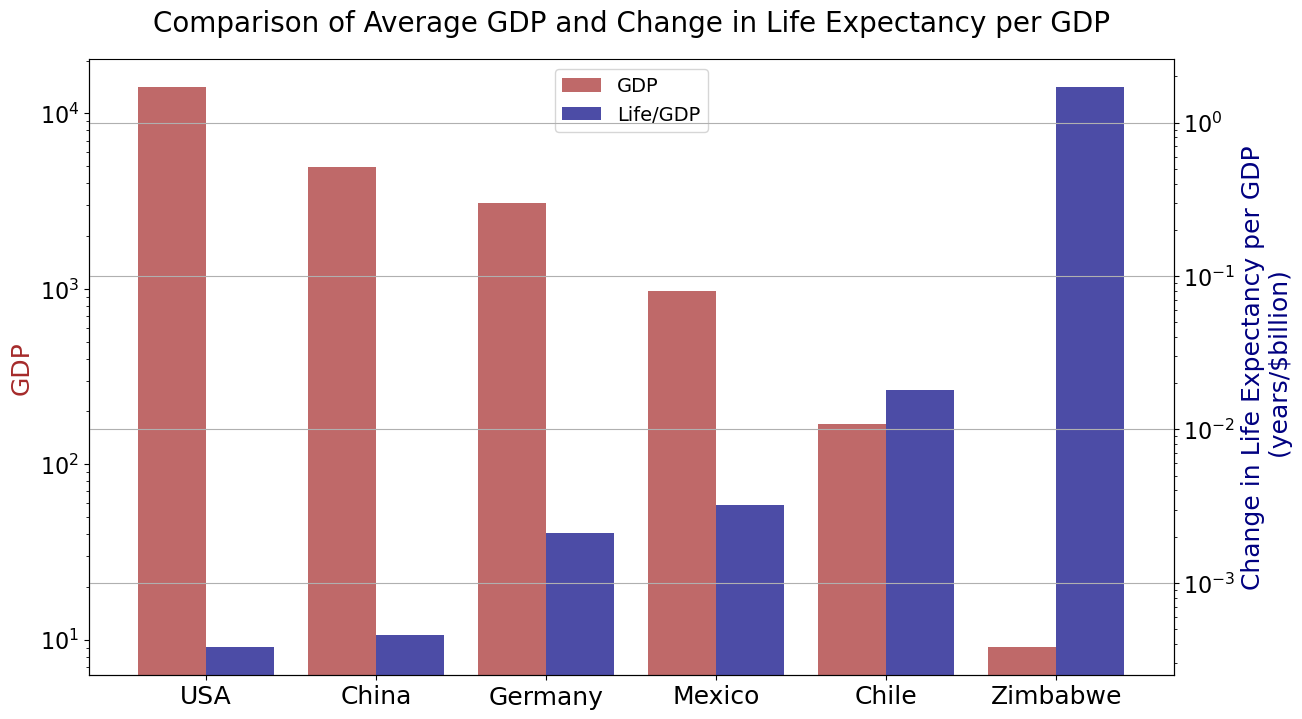

In [140]:
## Plot a comparison of average GDP to change in life expectancy per change in GDP
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(111)

color = 'brown'
plot1 = ax1.bar(countries, df_group_country_sort.gdp,
                align='edge', width=-0.4,
                label = "GDP", color=color, alpha=0.7)
ax1.set_yscale('log')

plt.title("Comparison of Average GDP and Change in Life Expectancy per GDP", fontsize =20, pad = 20)

plt.yticks(fontsize=16)
plt.xticks(fontsize = 18)
plt.ylabel("GDP", fontsize = 18, color = color)

ax2 = ax1.twinx()

color = 'navy'
plot2 = ax2.bar(countries, life_gdp_rate.values(),
                align='edge', width=0.4,
                label = "Life/GDP", color=color, alpha=0.7)

ax2.set_yscale('log')
plt.ylabel(f"Change in Life Expectancy per GDP\n (years/$billion)", fontsize = 18, color = color)
plt.yticks(fontsize=16)

plt.grid(axis = 'y')
ax2.spines['top'].set_visible(False)

# Combine the plots
plots = plot1 + plot2
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=9, fontsize=14)
plt.show()

Analysis:
- Is the influence of increase in economy (GDP) similar for all countries? The answer is no.
- Based on the data, you are expected to see higher increase in life expectancy per billion dollars of GDP if the economy is weak (i.e. low GDP). This applies to Zimbabwe, and to lesser extent, Chile.
- In contrast, for countries with strong economy, the increase in life expectancy due to the increase in GDP is very small. This applies to USA, and China, and to lesser extent, Germany and Mexico.
- The increase in life expectancy per increase in GDP is negatively correlated to the GDP. This could mean that GDP and the economy has a strong influence on the citizens' life expectancy, but once the country's GDP reaches a certain level, the life expectancy is no longer strongly influenced by the economy and more likely influenced by other factors.

In [193]:
df_group_country

,year,life_exp,gdp
country,,,
Chile,2007.5,78.94375,169.788845
China,2007.5,74.26250,4957.713750
Germany,2007.5,79.65625,3094.775625
Mexico,2007.5,75.71875,976.650625
USA,2007.5,78.06250,14075.000000
Zimbabwe,2007.5,50.09375,9.062580


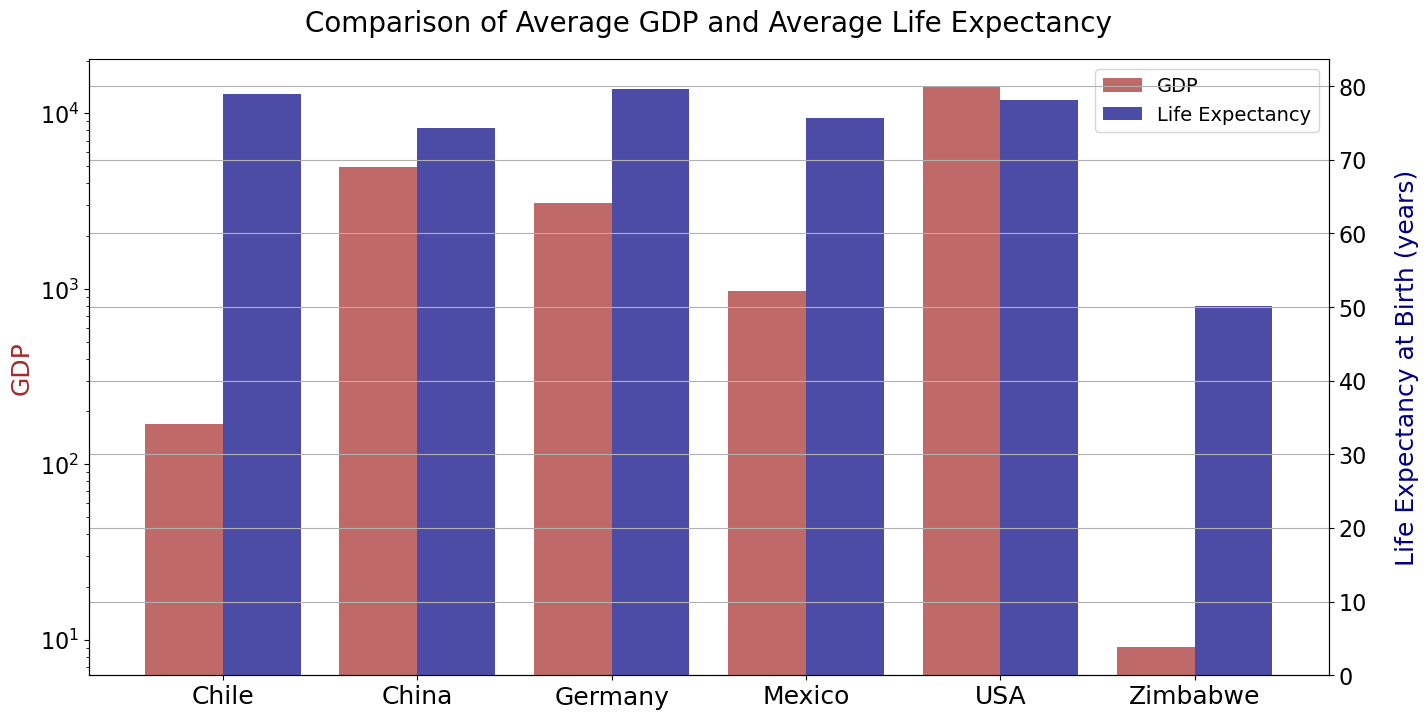

In [204]:
## Average Life & GDP Side-by-Side for Countries 
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

color = 'brown'
plot1 = ax1.bar(df_group_country.index, df_group_country.gdp,
                align='edge', width=-0.4,
                label = "GDP", color=color, alpha=0.7)
ax1.set_yscale('log')

plt.title("Comparison of Average GDP and Average Life Expectancy", fontsize =20, pad = 20)

plt.yticks(fontsize=16)
plt.xticks(fontsize = 18)
plt.ylabel("GDP", fontsize = 18, color = color)

ax2 = ax1.twinx()

color = 'navy'
plot2 = ax2.bar(df_group_country.index, df_group_country.life_exp,
                align='edge', width=0.4,
                label = "Life Expectancy", color=color, alpha=0.7)

plt.ylabel(f"Life Expectancy at Birth (years)", fontsize = 18, color = color, labelpad=20)
plt.yticks(fontsize=16)

plt.grid(axis = 'y')
ax2.spines['top'].set_visible(False)

# Combine the plots
plots = plot1 + plot2
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=1, fontsize=14)
plt.show()


Analysis:
- For most countries, the average life expectancy ranges between 70 and 80. 
- Germany has the highest average life expectancy, closely followed by Chile.
- Zimbabwe had the lowest average life expectancy, and coincidentally the lowest GDP by far.
- This plot reinforces the idea that economic factors (like GDP) plays a role in increasing the life expectancy to a certain point. However, once a country passes this point, other external factors other than economy plays a stronger role in increasing the life expectancy.

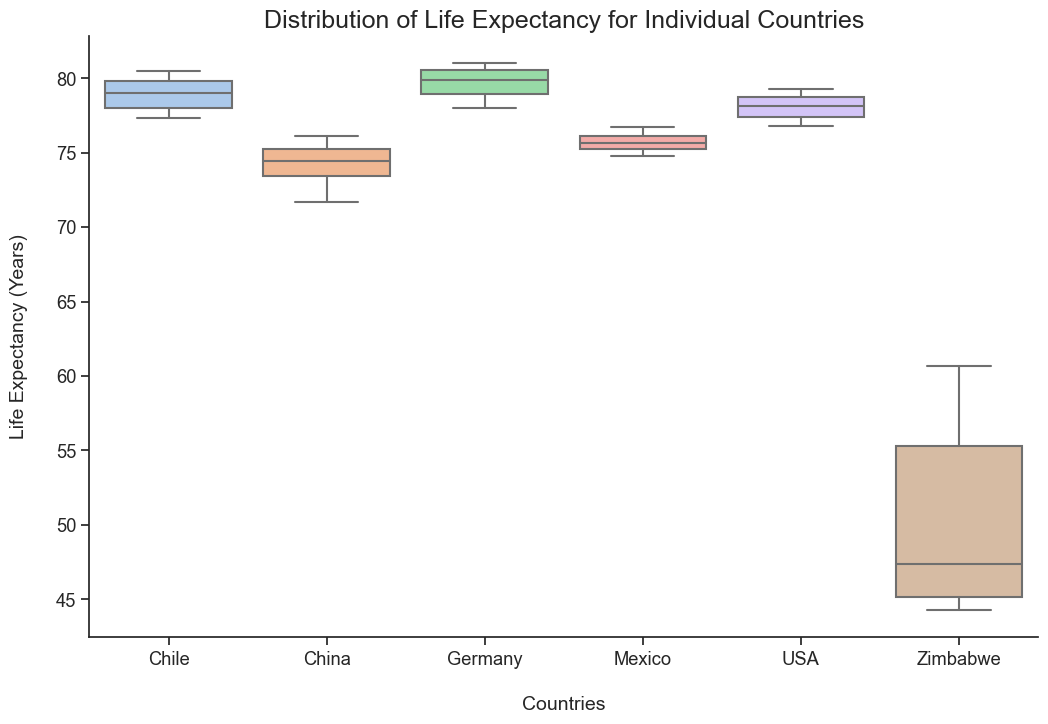

In [227]:
countries = list(df.country.unique())

## What is the distribution of that life expectancy?
sns.set_palette("Blues")
sns.set(rc={'axes.facecolor':sns.xkcd_rgb["light blue grey"], 
            'figure.facecolor':'white',
            'figure.figsize':(12,7)})
sns.set(font_scale = 1.2)

with sns.axes_style(style='ticks'):
    g = sns.catplot(x = "country", y = "life_exp", 
                    data=df, 
                    kind="box", 
                    height=7, aspect=15/10,
                    ax=ax,
                    palette="pastel")

plt.xlabel("Countries", fontsize=14, labelpad=20)
plt.ylabel("Life Expectancy (Years)", fontsize=14, labelpad=20)
plt.title(f"Distribution of Life Expectancy for Individual Countries",
          fontsize = 18)

ax.set_ylim(40, 90)

plt.show()

Analysis:
- There was very small variance in life expectancy during the 15 year span for most countries.
- Zimbabwe had the largest variance.

In [238]:
for country in countries:
    print(f"Distribution of Life Expectancy for {country.title()}:")
    df_temp = df.life_exp[df.country == country].describe()
    display(df_temp)

Distribution of Life Expectancy for Chile:


count    16.000000
mean     78.943750
std       1.058911
min      77.300000
25%      77.975000
50%      79.000000
75%      79.825000
max      80.500000
Name: life_exp, dtype: float64

Distribution of Life Expectancy for China:


count    16.000000
mean     74.262500
std       1.318016
min      71.700000
25%      73.400000
50%      74.450000
75%      75.250000
max      76.100000
Name: life_exp, dtype: float64

Distribution of Life Expectancy for Germany:


count    16.00000
mean     79.65625
std       0.97500
min      78.00000
25%      78.95000
50%      79.85000
75%      80.52500
max      81.00000
Name: life_exp, dtype: float64

Distribution of Life Expectancy for Mexico:


count    16.000000
mean     75.718750
std       0.620987
min      74.800000
25%      75.225000
50%      75.650000
75%      76.150000
max      76.700000
Name: life_exp, dtype: float64

Distribution of Life Expectancy for Usa:


count    16.000000
mean     78.062500
std       0.832566
min      76.800000
25%      77.425000
50%      78.150000
75%      78.725000
max      79.300000
Name: life_exp, dtype: float64

Distribution of Life Expectancy for Zimbabwe:


count    16.000000
mean     50.093750
std       5.940311
min      44.300000
25%      45.175000
50%      47.400000
75%      55.325000
max      60.700000
Name: life_exp, dtype: float64

Analysis:
- The interquartile range for each country is typically around 1 - 2 years, and the standard deviation is also around 1.0 years.
- Zimbabwe, on the other hand, has an interquartile range of 10 years and a standard deviation of 5.9 years.

## 4. Conclusion

Key takeaway messages are:
- For most countries, the average life expectancy ranges between 70 - 80 except Zimbabwe, which had the lowest average life expectancy at 50 years. This is due to multiple factors, for example, food crisis that occurred in Zimbabwe in the early 2000s.<br><br>
- The life expectancy for all countries increased during the 15-year span at a rate of 0.3 years per year. However, Zimbabwe, which had the lowest life expectancy of all six countries, saw its life expectancy increase at a faster rate of around 1.0 years per year.<br><br>
- The GDP also increased over time for all countries at an average rate of $219 billion per year, although some countries experienced negative growth during the 2007 recession.<br><br>
- There seems to a strong positive correlation between GDP and life expectancy. However, a closer inspection of the data revealed that while GDP contributes to the increase in life expectancy to some extent, it is likely there are other external factors (not shown in the data) that contribute to the increase in life expectancy.<br><br>
- __The extent of contribution of GDP to the increase in life expectancy seems to be negatively correlated to the size of the country's economy (GDP). The smaller the economy, the larger the contribution of GDP to the increase in life expectancy, and vice versa.__<br><br>